# Support Vector Regression (SVR) - By Foivos Gaitantzis

#### This section of the program is dedicated to fitting all the features post processing to a Support Vector Regression (SVR) Algorithm. An initial model is built using random hyperparametes. The hyperparameter values are then tweaked and a final model is built and evaluated. 

### Load the Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

### Define the Feature Engineering/Machine Learning Parameters & Utility Functions

In [2]:
#Set the filename
filename = 'aapl'

#Set the Default Columns, Timestep (Previous Historical Data to Use for Predictions) & Polynomial Degree
Columns = ['Adj Close', 'compoundFT', 'compoundNYTimes', 'compoundBS', 'Volume', 'RSI', 'MACD']
timestep = 3
kernel = 'rbf'
C = 10
gamma = 0.001
epsilon = 0.01

In [3]:
#Utility function to compute the mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

### Load the Data File & Perform Model Feature Engineering

In [4]:
#Load the Daily Stock Data
Data = pd.read_csv('files/'+filename+'_Stock_Data_Full.csv')

#Set the Date Column Type to Datetime
Data['Date'] = pd.to_datetime(Data['Date'], format='%Y-%m-%d')

#Create copies of the Data for Modification
Data_Edit = Data.copy()
Columns_Edit = Columns.copy()

#Create new to columns of Historical Data according to the timestep
for step in range(timestep):
    Columns_Edit.append('Adj Close'+str(step))
    Data_Edit['Adj Close'+str(step)] = Data_Edit['Adj Close']
    Data_Edit['Adj Close'+str(step)] = Data_Edit['Adj Close'+str(step)].shift(step)

#Remove all NaN values in Adj Close, Adj Close(0 - timestep), Predicted Adj Close, RSI and MACD
Data_Edit.dropna(inplace = True)

#Display the first 5 rows of the Modified Data Set
Data_Edit.head()

,Date,compoundFT,compoundNYTimes,compoundBS,Close,Volume,Adj Close,RSI,MACD,Predicted Adj Close,Adj Close0,Adj Close1,Adj Close2
7,2016-01-08,0.203480,0.043943,0.137486,96.959999,7.079800e+07,90.391907,14.668720,-0.370537,90.879794,90.391907,89.916473,93.878586
8,2016-01-09,0.377325,-0.008900,0.104625,97.483332,6.377847e+07,90.879794,14.832344,-0.384101,91.367681,90.879794,90.391907,89.916473
9,2016-01-10,0.515333,0.271481,0.135400,98.006666,5.675893e+07,91.367681,14.886746,-0.364081,91.855568,91.367681,90.879794,90.391907
10,2016-01-11,0.233810,0.375018,0.179233,98.529999,4.973940e+07,91.855568,14.913921,-0.321599,93.188705,91.855568,91.367681,90.879794
11,2016-01-12,0.155050,0.201992,0.397150,99.959999,4.915420e+07,93.188705,19.135019,-0.221146,90.792793,93.188705,91.855568,91.367681


In [5]:
#Split the Data into Training and Testing (Train: 80% & Testing: 20%)
train, test = train_test_split(Data_Edit, train_size = 0.8, test_size = 0.2, shuffle = False)

#Initiate two Scalers: one for the inputs & one for the output
ScalerX = StandardScaler()

#Seperate the train & test dataset into their inputs and output & perform scaling
x_train = ScalerX.fit_transform(train[Columns_Edit])
y_train = train[['Predicted Adj Close']]
x_test = ScalerX.transform(test[Columns_Edit])
y_test = test[['Predicted Adj Close']]

### Run the Primary Linear Regression Model using Default Parameters

In [6]:
#Initialize the Model
Model = SVR(kernel='rbf', C=C, epsilon=epsilon, gamma=gamma, coef0=0.1, shrinking=True, 
            tol=0.001, cache_size=200, verbose=False, max_iter=-1)

#Fit the Training Inputs and Output into the Model
Model.fit(x_train, np.array(y_train).ravel())

#Using the Test Inputs, Predict Values for Output
Prediction = Model.predict(x_test)

#Calculate the Root Mean Squared Error & the Mean Absolute Percentage Error
RMSE = math.sqrt(mean_squared_error(test['Predicted Adj Close'], Prediction))
MAPE = mean_absolute_percentage_error(test['Predicted Adj Close'], Prediction)

#Print the values of Accuracy, RMSE & MAPE
print("Accuracy: "+str(Model.score(x_test, np.array(y_test).ravel())))
print("RMSE: "+str(RMSE))
print("MAPE: "+str(MAPE))

#Create a Dataframe that stores the Date, the Actual Stock Value and the Predicted Stock Value
Prediction = pd.DataFrame({'Date': test['Date'], 'Actual Value': test['Predicted Adj Close'], 'Prediction': Prediction})

#Display the first 5 rows of this Dataframe
Prediction.head()

Accuracy: 0.9518983750475427
RMSE: 4.451149471156836
MAPE: 1.7946575415493036


,Date,Actual Value,Prediction
877,2018-05-27,183.560894,182.492356
878,2018-05-28,183.394974,182.553582
879,2018-05-29,183.004562,182.201591
880,2018-05-30,182.389633,182.137535
881,2018-05-31,185.678833,181.417537


### Display Primary Model Predictions vs Actual Values

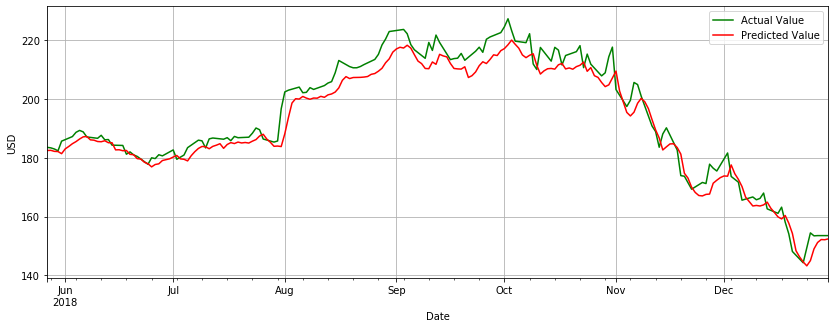

In [7]:
#Display a line graph of the Actual vs Predicted Values
plt.rcParams['figure.figsize'] = 14, 5 
AX = Prediction.plot(x='Date', y='Actual Value', style='g-', grid=True)
AX = Prediction.plot(x='Date', y='Prediction', style='r-', grid=True, ax=AX)
AX.legend(['Actual Value', 'Predicted Value'])
AX.set_xlabel("Date")
AX.set_ylabel("USD")
plt.show()

### Calculate the Optimal Columns Type

In [8]:
columns_list = [['Adj Close', 'Volume'], ['Adj Close', 'Volume', 'RSI', 'MACD'], ['Adj Close', 'Volume', 'compoundFT', 'compoundNYTimes'], Columns]
columns_headers = ['Just Historical Stock Data', 'Technical Analysis', 'Sentiment Analysis', 'Technical & Sentiment Analysis']

columns_errors = {'Columns' : [], 'Columns Type' : [], 'RMSE' : [], 'MAPE' : []}
i = 0

for column in columns_list:   
    
    Data_Edit = Data.copy()
    for step in range(timestep):
        Columns_Edit.append('Adj Close'+str(step))
        Data_Edit['Adj Close'+str(step)] = Data_Edit['Adj Close']
        Data_Edit['Adj Close'+str(step)] = Data_Edit['Adj Close'+str(step)].shift(step)
    
    #Remove all NaN values in Adj Close, Adj Close(0 - timestep), Predicted Adj Close, RSI and MACD
    Data_Edit.dropna(inplace = True)
    
    #Split the Data into Training and Testing (Train: 80% & Testing: 20%)
    train, test = train_test_split(Data_Edit, train_size = 0.8, test_size = 0.2, shuffle = False)

    #Initiate two Scalers: one for the inputs & one for the output
    ScalerX = StandardScaler()

    #Seperate the train & test dataset into their inputs and output & perform scaling
    x_train = ScalerX.fit_transform(train[column])
    y_train = train[['Predicted Adj Close']]
    x_test = ScalerX.transform(test[column])
    y_test = test[['Predicted Adj Close']]
    
    #Initialize the Model
    Model = SVR(kernel='rbf', C=C, epsilon=epsilon, gamma=gamma, coef0=0.1, shrinking=True, 
                tol=0.001, cache_size=200, verbose=False, max_iter=-1)

    #Fit the Training Inputs and Output into the Model
    Model.fit(x_train, np.array(y_train).ravel())
    
    #Using the Test Inputs, Predict Values for Output
    Prediction = Model.predict(x_test)

    #Print the values of Accuracy, RMSE & MAPE
    RMSE = math.sqrt(mean_squared_error(test['Predicted Adj Close'], Prediction))
    MAPE = mean_absolute_percentage_error(test['Predicted Adj Close'], Prediction)
    
    #Input the Columns, Columns Type & Errors to the Dataframe
    columns_errors['Columns'].append(column)
    columns_errors['Columns Type'].append(columns_headers[i])
    columns_errors['RMSE'].append(RMSE)
    columns_errors['MAPE'].append(MAPE)
    
    i+=1
    
columns_errors = pd.DataFrame(columns_errors)
                              
#Set the Data Column as Index Column
columns_errors = columns_errors.set_index('Columns Type')

#Print the Optimal Columns Type
OptimalParameter = columns_errors[columns_errors['RMSE'] == columns_errors['RMSE'].min()]
Columns = OptimalParameter['Columns'].values[0]
print("Optimal Parameter (Based on RMSE): "+str(OptimalParameter.index.values[0])+", RMSE: "+str(OptimalParameter['RMSE'].values[0]))

#Show each Columns Type and Error Associated
columns_errors[['RMSE', 'MAPE']].head()

Optimal Parameter (Based on RMSE): Just Historical Stock Data, RMSE: 32.419575397505255


,RMSE,MAPE
Columns Type,,
Just Historical Stock Data,32.419575,15.522962
Technical Analysis,33.063145,16.109405
Sentiment Analysis,33.386732,16.027677
Technical & Sentiment Analysis,34.440524,16.849070


### Calculate the Optimal Timestep

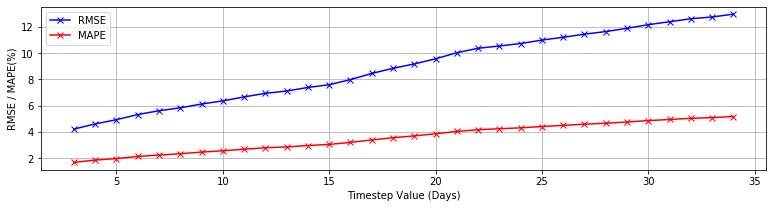

Optimal Parameter (Based on RMSE): 3, RMSE: 4.222332960808433


In [9]:
timestep_list = range(3, 35)

timestep_errors = {'Timestep' : [], 'RMSE' : [], 'MAPE' : []}

for step in timestep_list:   
    
    Columns_Edit = Columns.copy()
    Data_Edit = Data.copy()
    for step_update in range(step):
        Columns_Edit.append('Adj Close'+str(step_update))
        Data_Edit['Adj Close'+str(step_update)] = Data_Edit['Adj Close']
        Data_Edit['Adj Close'+str(step_update)] = Data_Edit['Adj Close'+str(step_update)].shift(step_update)

    #Remove all NaN values in Adj Close, Adj Close(0 - timestep), Predicted Adj Close, RSI and MACD
    Data_Edit.dropna(inplace = True)
    
    #Split the Data into Training and Testing (Train: 80% & Testing: 20%)
    train, test = train_test_split(Data_Edit, train_size = 0.8, test_size = 0.2, shuffle = False)

    #Initiate two Scalers: one for the inputs & one for the output
    ScalerX = StandardScaler()

    #Seperate the train & test dataset into their inputs and output & perform scaling
    x_train = ScalerX.fit_transform(train[Columns_Edit])
    y_train = train[['Predicted Adj Close']]
    x_test = ScalerX.transform(test[Columns_Edit])
    y_test = test[['Predicted Adj Close']]
    
    #Initialize the Model
    Model = SVR(kernel='rbf', C=C, epsilon=epsilon, gamma=gamma, coef0=0.1, shrinking=True, 
                tol=0.001, cache_size=200, verbose=False, max_iter=-1)

    #Fit the Training Inputs and Output into the Model
    Model.fit(x_train, np.array(y_train).ravel())
    
    #Using the Test Inputs, Predict Values for Output
    Prediction = Model.predict(x_test)

    #Print the values of Accuracy, RMSE & MAPE
    RMSE = math.sqrt(mean_squared_error(test['Predicted Adj Close'], Prediction))
    MAPE = mean_absolute_percentage_error(test['Predicted Adj Close'], Prediction)
    
    #Input the Timestep & Errors to the Dataframe
    timestep_errors['Timestep'].append(step)
    timestep_errors['RMSE'].append(RMSE)
    timestep_errors['MAPE'].append(MAPE)
    
timestep_errors = pd.DataFrame(timestep_errors)

#Plot the Errors against the Timestep
plt.rcParams['figure.figsize'] = 13, 3 
AX = timestep_errors.plot(x='Timestep', y='RMSE', style='bx-', grid=True)
AX = timestep_errors.plot(x='Timestep', y='MAPE', style='rx-', grid=True, ax=AX)
AX.set_xlabel("Timestep Value (Days)")
AX.set_ylabel("RMSE / MAPE(%)")
plt.show()

#Print the Optimal Timestep and Set it to the Default
OptimalParameter = timestep_errors[timestep_errors['RMSE'] == timestep_errors['RMSE'].min()]
timestep = OptimalParameter['Timestep'].values[0]
print("Optimal Parameter (Based on RMSE): "+str(OptimalParameter['Timestep'].values[0])+", RMSE: "+str(OptimalParameter['RMSE'].values[0]))

### Calculate the Optimal C and Gamma parameters

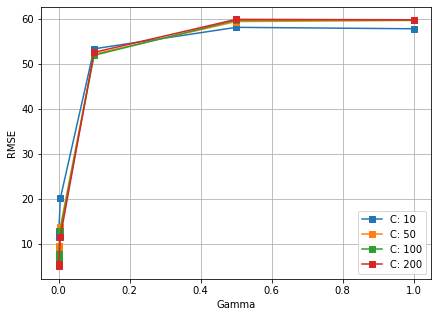

Optimal Parameter (Based on RMSE) -> C: 200, Gamma: 0.0001, RMSE: 5.021739551774435


In [12]:
C_list = [10, 50, 100, 200]
gamma_list = [0.0001, 0.001, 0.005, 0.1, 0.5, 1]

errors = {'C' : [], 'Gamma': [], 'RMSE' : [], 'MAPE' : []}

for unit_c in C_list:
    for unit_gamma in gamma_list:

        Columns_Edit = Columns.copy()
        Data_Edit = Data.copy()
        for step_update in range(step):
            Columns_Edit.append('Adj Close'+str(step_update))
            Data_Edit['Adj Close'+str(step_update)] = Data_Edit['Adj Close']
            Data_Edit['Adj Close'+str(step_update)] = Data_Edit['Adj Close'+str(step_update)].shift(step_update)

        #Remove all NaN values in Adj Close, Adj Close(0 - timestep), Predicted Adj Close, RSI and MACD
        Data_Edit.dropna(inplace = True)

        #Split the Data into Training and Testing (Train: 80% & Testing: 20%)
        train, test = train_test_split(Data_Edit, train_size = 0.8, test_size = 0.2, shuffle = False)

        #Initiate two Scalers: one for the inputs & one for the output
        ScalerX = StandardScaler()

        #Seperate the train & test dataset into their inputs and output & perform scaling
        x_train = ScalerX.fit_transform(train[Columns_Edit])
        y_train = train[['Predicted Adj Close']]
        x_test = ScalerX.transform(test[Columns_Edit])
        y_test = test[['Predicted Adj Close']]

        #Initialize the Model
        Model = SVR(kernel='rbf', C=unit_c, epsilon=epsilon, gamma=unit_gamma, coef0=0.1, shrinking=True, 
                    tol=0.001, cache_size=200, verbose=False, max_iter=-1)

        #Fit the Training Inputs and Output into the Model
        Model.fit(x_train, np.array(y_train).ravel())

        #Using the Test Inputs, Predict Values for Output
        Prediction = Model.predict(x_test)

        #Print the values of Accuracy, RMSE & MAPE
        RMSE = math.sqrt(mean_squared_error(test['Predicted Adj Close'], Prediction))
        MAPE = mean_absolute_percentage_error(test['Predicted Adj Close'], Prediction)
    

        #Input the Epochs, Batch Size & Errors to the Dataframe
        errors['C'].append(unit_c)
        errors['Gamma'].append(unit_gamma)
        errors['RMSE'].append(RMSE)
        errors['MAPE'].append(MAPE)
    
errors = pd.DataFrame(errors)

#Plot the Errors against the Timestep
legend_list = []
plt.rcParams['figure.figsize'] = 7, 5 
error = errors[errors['C'] == C_list[0]]
AX = error.plot(x='Gamma', y='RMSE', marker='s', grid=True)
legend_list.append("C: "+str(C_list[0]))

for i in range(1, len(C_list)):
    error = errors[errors['C'] == C_list[i]]
    AX = error.plot(x='Gamma', y='RMSE', marker='s', grid=True, ax=AX)
    legend_list.append("C: "+str(C_list[i]))
    
AX.set_xlabel("Gamma")
AX.set_ylabel("RMSE")
plt.legend(legend_list)
plt.show()

#Print the Optimal Timestep and Set it to the Default
OptimalParameter = errors[errors['RMSE'] == errors['RMSE'].min()]
C = OptimalParameter['C'].values[0]
gamma = OptimalParameter['Gamma'].values[0]
print("Optimal Parameter (Based on RMSE) -> C: "+str(OptimalParameter['C'].values[0])+", Gamma: "+str(OptimalParameter['Gamma'].values[0])+", RMSE: "+str(OptimalParameter['RMSE'].values[0]))

### Calculate the Optimal Epsilon Parameter

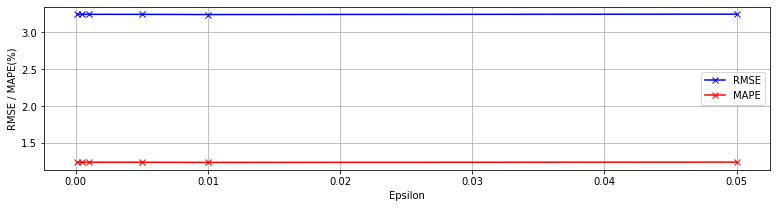

Optimal Parameter (Based on RMSE): 0.01, RMSE: 3.237954532331737


In [13]:
epsilon_list = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]

epsilon_errors = {'Epsilon' : [], 'RMSE' : [], 'MAPE' : []}

for eps in epsilon_list:   
    
    Columns_Edit = Columns.copy()
    Data_Edit = Data.copy()
    for step_update in range(timestep):
        Columns_Edit.append('Adj Close'+str(step_update))
        Data_Edit['Adj Close'+str(step_update)] = Data_Edit['Adj Close']
        Data_Edit['Adj Close'+str(step_update)] = Data_Edit['Adj Close'+str(step_update)].shift(step_update)

    #Remove all NaN values in Adj Close, Adj Close(0 - timestep), Predicted Adj Close, RSI and MACD
    Data_Edit.dropna(inplace = True)
    
    #Split the Data into Training and Testing (Train: 80% & Testing: 20%)
    train, test = train_test_split(Data_Edit, train_size = 0.8, test_size = 0.2, shuffle = False)

    #Initiate two Scalers: one for the inputs & one for the output
    ScalerX = StandardScaler()

    #Seperate the train & test dataset into their inputs and output & perform scaling
    x_train = ScalerX.fit_transform(train[Columns_Edit])
    y_train = train[['Predicted Adj Close']]
    x_test = ScalerX.transform(test[Columns_Edit])
    y_test = test[['Predicted Adj Close']]
    
    #Initialize the Model
    Model = SVR(kernel='rbf', C=C, epsilon=eps, gamma=gamma, coef0=0.1, shrinking=True, 
                tol=0.001, cache_size=200, verbose=False, max_iter=-1)

    #Fit the Training Inputs and Output into the Model
    Model.fit(x_train, np.array(y_train).ravel())
    
    #Using the Test Inputs, Predict Values for Output
    Prediction = Model.predict(x_test)

    #Print the values of Accuracy, RMSE & MAPE
    RMSE = math.sqrt(mean_squared_error(test['Predicted Adj Close'], Prediction))
    MAPE = mean_absolute_percentage_error(test['Predicted Adj Close'], Prediction)
    
    #Input the Timestep & Errors to the Dataframe
    epsilon_errors['Epsilon'].append(eps)
    epsilon_errors['RMSE'].append(RMSE)
    epsilon_errors['MAPE'].append(MAPE)
    
epsilon_errors = pd.DataFrame(epsilon_errors)

#Plot the Errors against the Timestep
plt.rcParams['figure.figsize'] = 13, 3 
AX = epsilon_errors.plot(x='Epsilon', y='RMSE', style='bx-', grid=True)
AX = epsilon_errors.plot(x='Epsilon', y='MAPE', style='rx-', grid=True, ax=AX)
AX.set_xlabel("Epsilon")
AX.set_ylabel("RMSE / MAPE(%)")
plt.show()

#Print the Optimal Timestep and Set it to the Default
OptimalParameter = epsilon_errors[epsilon_errors['RMSE'] == epsilon_errors['RMSE'].min()]
epsilon = OptimalParameter['Epsilon'].values[0]
print("Optimal Parameter (Based on RMSE): "+str(OptimalParameter['Epsilon'].values[0])+", RMSE: "+str(OptimalParameter['RMSE'].values[0]))

### Calculate the Optimal Kernel 

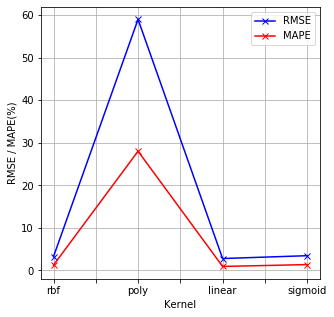

Optimal Parameter (Based on RMSE): linear, RMSE: 2.783954877225662


In [14]:
kernel_list = ['rbf', 'poly', 'linear', 'sigmoid']

kernel_errors = {'Kernel' : [], 'RMSE' : [], 'MAPE' : []}

for ker in kernel_list:   
    
    Columns_Edit = Columns.copy()
    Data_Edit = Data.copy()
    for step_update in range(timestep):
        Columns_Edit.append('Adj Close'+str(step_update))
        Data_Edit['Adj Close'+str(step_update)] = Data_Edit['Adj Close']
        Data_Edit['Adj Close'+str(step_update)] = Data_Edit['Adj Close'+str(step_update)].shift(step_update)

    #Remove all NaN values in Adj Close, Adj Close(0 - timestep), Predicted Adj Close, RSI and MACD
    Data_Edit.dropna(inplace = True)
    
    #Split the Data into Training and Testing (Train: 80% & Testing: 20%)
    train, test = train_test_split(Data_Edit, train_size = 0.8, test_size = 0.2, shuffle = False)

    #Initiate two Scalers: one for the inputs & one for the output
    ScalerX = StandardScaler()

    #Seperate the train & test dataset into their inputs and output & perform scaling
    x_train = ScalerX.fit_transform(train[Columns_Edit])
    y_train = train[['Predicted Adj Close']]
    x_test = ScalerX.transform(test[Columns_Edit])
    y_test = test[['Predicted Adj Close']]
    
    #Initialize the Model
    Model = SVR(kernel=ker, C=C, epsilon=epsilon, gamma=gamma, coef0=0.1, shrinking=True, 
                tol=0.001, cache_size=200, verbose=False, max_iter=-1)

    #Fit the Training Inputs and Output into the Model
    Model.fit(x_train, np.array(y_train).ravel())
    
    #Using the Test Inputs, Predict Values for Output
    Prediction = Model.predict(x_test)

    #Print the values of Accuracy, RMSE & MAPE
    RMSE = math.sqrt(mean_squared_error(test['Predicted Adj Close'], Prediction))
    MAPE = mean_absolute_percentage_error(test['Predicted Adj Close'], Prediction)
    
    #Input the Timestep & Errors to the Dataframe
    kernel_errors['Kernel'].append(ker)
    kernel_errors['RMSE'].append(RMSE)
    kernel_errors['MAPE'].append(MAPE)
    
kernel_errors = pd.DataFrame(kernel_errors)

#Plot the Errors against the Timestep
plt.rcParams['figure.figsize'] = 5, 5 
AX = kernel_errors.plot(x='Kernel', y='RMSE', style='bx-', grid=True)
AX = kernel_errors.plot(x='Kernel', y='MAPE', style='rx-', grid=True, ax=AX)
AX.set_xlabel("Kernel")
AX.set_ylabel("RMSE / MAPE(%)")
plt.show()

#Print the Optimal Timestep and Set it to the Default
OptimalParameter = kernel_errors[kernel_errors['RMSE'] == kernel_errors['RMSE'].min()]
kernel = OptimalParameter['Kernel'].values[0]
print("Optimal Parameter (Based on RMSE): "+str(OptimalParameter['Kernel'].values[0])+", RMSE: "+str(OptimalParameter['RMSE'].values[0]))

### Final Model (including Feature Engineering)

In [15]:
#Create copies of the Data for Modification
Data_Edit = Data.copy()
Columns_Edit = Columns.copy()

#Create new to columns of Historical Data according to the timestep
for step in range(timestep):
    Columns_Edit.append('Adj Close'+str(step))
    Data_Edit['Adj Close'+str(step)] = Data_Edit['Adj Close']
    Data_Edit['Adj Close'+str(step)] = Data_Edit['Adj Close'+str(step)].shift(step)

#Remove all NaN values in Adj Close, Adj Close(0 - timestep), Predicted Adj Close, RSI and MACD
Data_Edit.dropna(inplace = True)

#Split the Data into Training and Testing (Train: 80% & Testing: 20%)
train, test = train_test_split(Data_Edit, train_size = 0.8, test_size = 0.2, shuffle = False)

#Initiate two Scalers: one for the inputs & one for the output
ScalerX = StandardScaler()

#Seperate the train & test dataset into their inputs and output & perform scaling
x_train = ScalerX.fit_transform(train[Columns_Edit])
y_train = train[['Predicted Adj Close']]
x_test = ScalerX.transform(test[Columns_Edit])
y_test = test[['Predicted Adj Close']]

In [18]:
#Initialize the Model
Model = SVR(kernel=kernel, C=C, epsilon=epsilon, gamma=gamma, coef0=0.1, shrinking=True, 
            tol=0.001, cache_size=200, verbose=False, max_iter=-1)

#Fit the Training Inputs and Output into the Model
Model.fit(x_train, np.array(y_train).ravel())
    
#Using the Test Inputs, Predict Values for Output
Prediction = Model.predict(x_test)

#Print the values of Accuracy, RMSE & MAPE
RMSE = math.sqrt(mean_squared_error(test['Predicted Adj Close'], Prediction))
MAPE = mean_absolute_percentage_error(test['Predicted Adj Close'], Prediction)
#Print the values of Accuracy, RMSE & MAPE
print("Accuracy: "+str(Model.score(x_test, np.array(y_test).ravel())))
print("RMSE: "+str(RMSE))
print("MAPE: "+str(MAPE))

#Create a Dataframe that stores the Date, the Actual Stock Value and the Predicted Stock Value
Prediction = pd.DataFrame({'Date': test['Date'], 'Actual Value': test['Predicted Adj Close'], 'Prediction': Prediction})

#Display the first 5 rows of this Dataframe
Prediction.head()

Accuracy: 0.9811834596979385
RMSE: 2.783954877225662
MAPE: 0.9227660087711861


,Date,Actual Value,Prediction
877,2018-05-27,183.560894,183.668464
878,2018-05-28,183.394974,183.496350
879,2018-05-29,183.004562,183.324236
880,2018-05-30,182.389633,182.927288
881,2018-05-31,185.678833,182.235056


### Display Final Model Predictions vs Actual Values

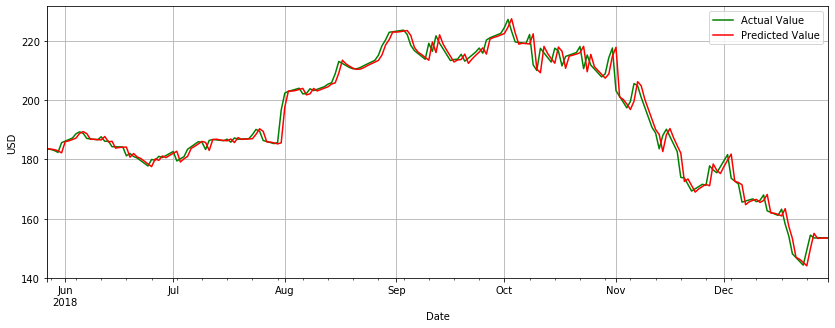

In [19]:
#Display a line graph of the Actual vs Predicted Values
plt.rcParams['figure.figsize'] = 14, 5 
AX = Prediction.plot(x='Date', y='Actual Value', style='g-', grid=True)
AX = Prediction.plot(x='Date', y='Prediction', style='r-', grid=True, ax=AX)
AX.legend(['Actual Value', 'Predicted Value'])
AX.set_xlabel("Date")
AX.set_ylabel("USD")
plt.show()